# Temporal analysis



In [1]:
import glob
import h5py
import librosa
import numpy as np
import os
import scipy.signal
import sys
import tqdm
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

%load_ext rpy2.ipython
%R library(lme4)

sys.path.append("..")
import localmodule
np.random.seed(2)

## Define functions
These functions are used to detect vocal activity, and threshold the activity into sound events that can be counted. 

In [2]:
n_species = 10

# t-2 Voice Activity Detection function
def detect_activity(y, sr,
        n_mels=128, fmin=1000, fmax=11025, 
        hop_length=512, gain=0.8, bias=10, power=0.25, pcen_time_constant=0.06, eps=1e-06,
        medfilt_time_constant=None, normalized=True,
        peak_threshold=0.45, activity_threshold=0.2):
    
    # 1. Compute mel-frequency spectrogram
    melspec = librosa.feature.melspectrogram(
        y, sr=sr, fmin=fmin, fmax=fmax, hop_length=hop_length,
        n_mels=n_mels)
    
    # 2. Compute per-channel energy normalization (PCEN-SNR)
    pcen = librosa.core.pcen(melspec, sr=sr, gain=gain, bias=bias,
        power=power, hop_length=hop_length,
        time_constant=pcen_time_constant, eps=eps)
    
    # 3. compute PCEN-SNR detection function
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    if normalized:
        pcen_snr = pcen_snr / np.max(pcen_snr)
        
    # 4. Apply median filtering.
    if medfilt_time_constant is not None:
        medfilt_hops = medfilt_time_constant * sr / hop_length
        kernel_size = max(1, 1 + 2 * round(medfilt_hops - 0.5))
        pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
    
    # 5. Extract active segments.
    activity, start, end = threshold_activity(
        pcen_snr, peak_threshold, activity_threshold)
    
    # 6. Convert indices to seconds.
    start_times = np.round(np.array(start) * hop_length / sr, 3)
    end_times = np.round(np.array(end) * hop_length / sr, 3)
    
    return start_times, end_times, pcen


def threshold_activity(x, Tp, Ta):
    locs = scipy.signal.find_peaks(x,height = Tp)[0]
    y = (x > Ta) * 1
    act = np.diff(y)
    u = np.where(act == 1)[0]
    d = np.where(act == -1)[0]
    signal_length = len(x)
    
    if u.any():

        if d[0] < u[0]:
            u = np.insert(u, 0, 0)

        if d[-1] < u[-1]:
            d = np.append(d, signal_length-1)

        starts = []
        ends = []

        activity = np.zeros(signal_length,)

        for candidate_up, candidate_down in zip(u, d):
            candidate_segment = range(candidate_up, candidate_down)
            peaks_in_segment = [x in candidate_segment for x in locs]
            is_valid_candidate = np.any(peaks_in_segment)
            if is_valid_candidate:
                starts.append(candidate_up)
                ends.append(candidate_down)
                activity[candidate_segment] = 1.0

        starts = np.array(starts)
        ends = np.array(ends)
    
    else:
        activity, starts, ends = [], [], []

    return activity, starts, ends

## Load data
The data was originally in .mat files. Here we load the data into numpy arrays. 

In [3]:
data_dir = localmodule.get_data_dir()
participant_paths = glob.glob("imitations_participant*.mat")
participant_paths.sort()
n_participants = len(participant_paths)
n_imitations = 100
imitation_matrix = []
species_matrix = []

for participant_path in tqdm.tqdm(participant_paths):
    imitation_list = []
    species_list = []
    
    with h5py.File(participant_path, 'r') as h5_file:
        for i in range(n_imitations):
            imitation_waveform = h5_file['#refs#'][
                h5_file["imitations"]["imitationAudio"][i][0]][0]
            species = int(h5_file['#refs#'][
                h5_file["imitations"]["species"][i][0]][0][0])
            imitation_list.append(imitation_waveform)
            species_list.append(species)
        imitation_matrix.append(imitation_list)
        species_matrix.append(species_list)
imitation_matrix = np.array(imitation_matrix)
species_matrix = np.array(species_matrix)

stimuli_waveform = []
with h5py.File(participant_paths[0], 'r') as h5_file:
    for i in range(n_imitations):
        stimulus_waveform = h5_file["#refs#"][h5_file["imitations"]["stimulusAudio"][i][0]][0]
        stimuli_waveform.append(stimulus_waveform)

100%|██████████| 17/17 [00:13<00:00,  1.33it/s]


## Count sound events
Here we detect vocal activity and count the number of sound events in the stimuli and its imitations

In [4]:
sr = 44100
medfilt_time_constant = 0.05
stimuli_counts = np.zeros((n_imitations,))
imitation_counts = np.zeros((n_participants, n_imitations))

for stimulus_id, stimulus_waveform in tqdm.tqdm(enumerate(stimuli_waveform)):
    starts, stops, _ = detect_activity(stimulus_waveform, sr,
            medfilt_time_constant=medfilt_time_constant)
    stimuli_counts[stimulus_id] = len(starts)
    
    for participant_id in range(n_participants):
        starts, stops, _ = detect_activity(imitation_matrix[participant_id, stimulus_id], sr,
            medfilt_time_constant=medfilt_time_constant)
        imitation_counts[participant_id, stimulus_id] = len(starts)

100it [00:44,  1.71it/s]


In [16]:
import pandas as pd


data = pd.DataFrame({"species":list(np.ravel(np.tile(species_list, (n_participants, 1)))),
        "stimulus_counts":list(np.ravel(np.tile(stimuli_counts, (n_participants, 1)))),
        "imitation_counts":list(np.ravel(imitation_counts))})


import statsmodels.api as sm
import statsmodels.formula.api as smf
md = smf.mixedlm("imitation_counts ~ stimulus_count", 
                 groups=data["species"],
                 data=data)
                 
mdf = md.fit()
print(mdf.summary())

# exog_re=data["imitation_counts"],                 exog_vc=data["stimulus_counts"],


AssertionError: 

In [14]:

data = sm.datasets.get_rdataset("dietox", "geepack").data
md = smf.mixedlm("Weight ~ Time", 
                 data, 
                 groups=data["Pig"])
mdf = md.fit()
print(mdf.summary())

AssertionError: 

In [ ]:

import statsmodels.api as sm
import statsmodels.formula.api as smf
data = sm.datasets.get_rdataset("dietox", "geepack").data
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit()
print(mdf.summary())

## Visualization
Here we compare the number of sound events in the stimuli and their imitations using scatter plots to estimate the correlation

/home/kendra/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/kendra/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 216x756 with 0 Axes>

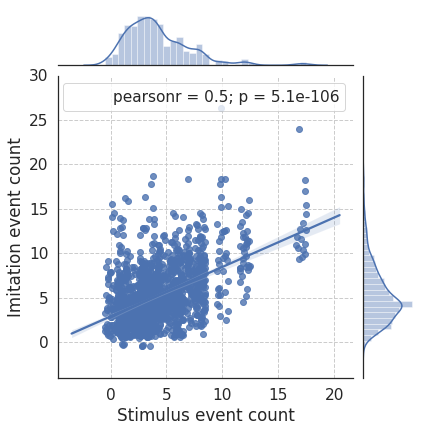

In [24]:
# SCATTER PLOT
import scipy.stats as stats
sns.set(style="white", color_codes=True, font_scale=1.4)

gridsize=60
marker_size = 8
jitter = .5
#yticks_diff = range(-6, 25, 2)
confidence_interval = 95

plt.figure(figsize=(3,10.5))
axis_font_size = 14
################################################################################
# IMITATION COUNTS VS. STIMULUS COUNTS
#ax1.text(0.05, .95, 'B', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

x=np.ravel(np.tile(stimuli_counts, (n_participants, 1))) \
        + np.random.rand((n_participants*n_imitations)) - jitter
y=np.ravel(imitation_counts) + np.random.rand((n_participants*n_imitations)) - jitter

fig = sns.jointplot(x=x, y=y, kind='reg')
fig.annotate(stats.pearsonr)

plt.xlabel("Stimulus event count")#, fontsize=axis_font_size)
plt.ylabel("Imitation event count")#, fontsize=axis_font_size)

#for n_participant in range(17): 
#    plt.scatter(
#        x=stimuli_counts, y = imitation_counts[n_participant, :])
        #marker='.', alpha=1.0, cmap='Set1', 
        #label=species_strings[species_id],
        #label=species_names_with_sci_names[species_id],
        #s=marker_size)
    
#xticks = range(0, 18, 5)
#yticks = range(0, 30, 5)
#plt.gca().set_xticks(xticks)#
#plt.gca().set_yticks(yticks)
#plt.ylim([-1, 30])
#plt.xlim([-1, 18])
#plt.xlim((-1, 10))
plt.grid(linestyle='--')


#plt.savefig("../figures/vihar2019_segmentation_scatters.png", dpi=1000, bbox_inches="tight")
#plt.savefig("../figures/vihar2019_segmentation_scatters.eps", bbox_inches="tight")

In [ ]:
################################################################################
# (DIFFERENCE BETWEEN STIMULUS & IMITATION COUNTS) VS. STIMULUS COUNTS
ax3 = plt.subplot(1,2,2)
ax3.text(0.05, .95, 'C', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')

imit_counts = np.ravel(imitation_counts)
stim_counts = np.ravel(np.tile(stimuli_counts, (n_participants, 1)))
diff = stim_counts - imit_counts

sns.regplot(
        stim_counts + np.random.rand((n_imitations * n_participants)) - jitter, 
        diff + np.random.rand((n_imitations * n_participants)) - jitter,  
        marker='.', scatter_kws={'s':marker_size}, ci=confidence_interval) #, fit_reg=False)

plt.xlabel("Stimulus count", fontsize=axis_font_size)
plt.ylabel("Stimulus count minus\n imitation count", fontsize=axis_font_size)
ax1.tick_params(axis='x', labelsize=axis_font_size)
ax1.tick_params(axis='y', labelsize=axis_font_size)
#plt.gca().set_xticks(xticks)
#plt.gca().set_yticks(yticks_diff)
#plt.xlim((-1, 10))
plt.grid(linestyle='--')


plt.tight_layout()